<a href="https://colab.research.google.com/github/DavideGioiosa/CNN_Speech_Recognition/blob/master/RVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regression Variational Autoencoder

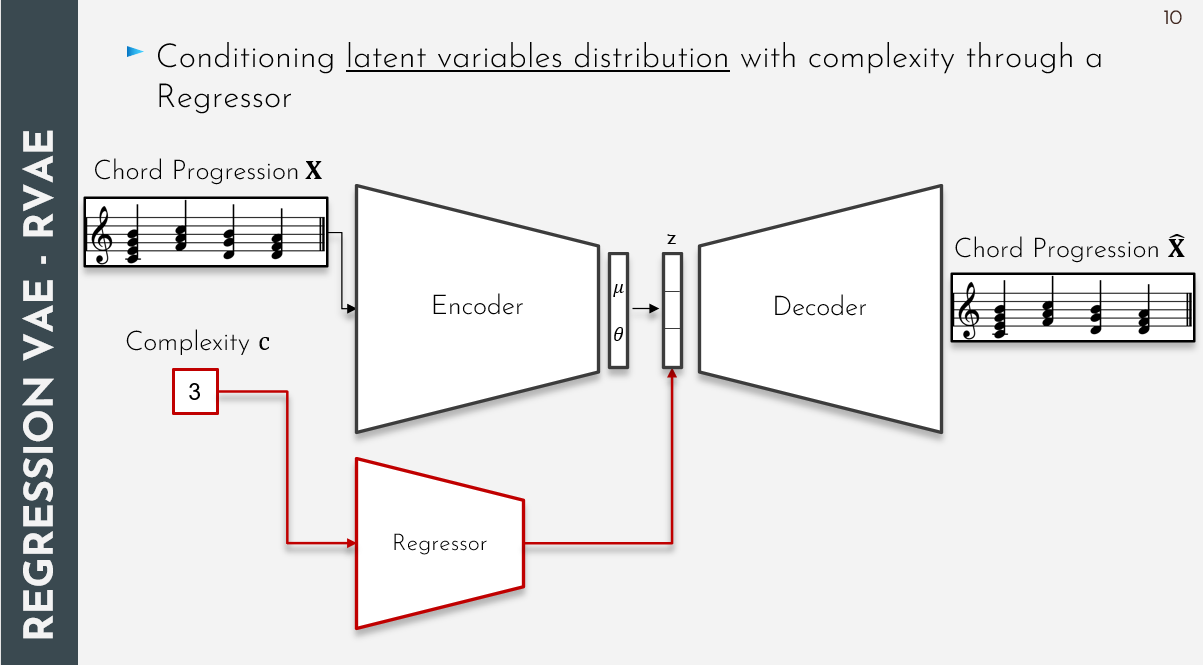

 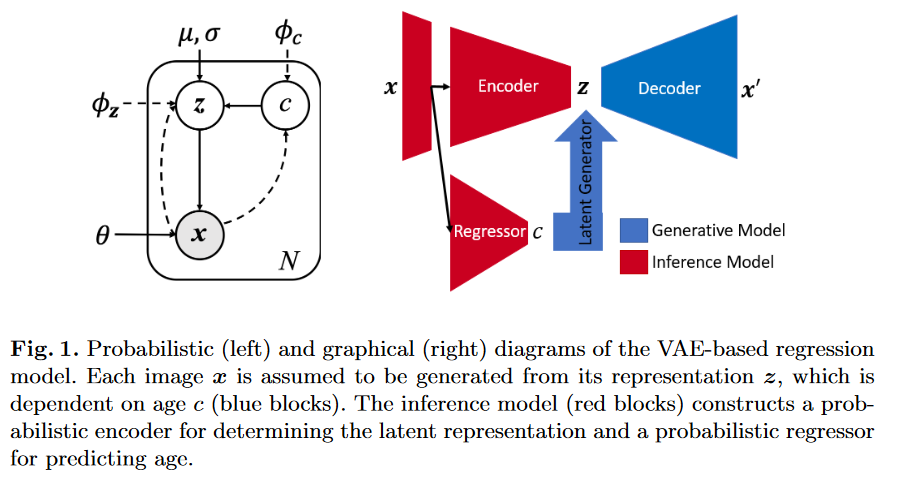


In [1]:
! git clone https://github.com/DavideGioiosa/master-thesis-polimi.git

Cloning into 'master-thesis-polimi'...
remote: Enumerating objects: 199, done.
remote: Counting objects: 100% (199/199), done.
remote: Compressing objects: 100% (160/160), done.
remote: Total 199 (delta 92), reused 92 (delta 29), pack-reused 0
Receiving objects: 100% (199/199), 4.28 MiB | 14.82 MiB/s, done.
Resolving deltas: 100% (92/92), done.


In [2]:
import os
os.chdir('/content/master-thesis-polimi')
os.getcwd()

'/content/master-thesis-polimi'

In [3]:
! pip install -r requirements.txt

     |████████████████████████████████| 20.1 MB 1.4 MB/s 
     |████████████████████████████████| 320.4 MB 48 kB/s 
     |████████████████████████████████| 11.2 MB 43.3 MB/s 
     |████████████████████████████████| 1.0 MB 40.1 MB/s 
     |████████████████████████████████| 459 kB 35.6 MB/s 
     |████████████████████████████████| 2.9 MB 44.1 MB/s 
     |████████████████████████████████| 895 kB 61.1 MB/s 
  Created wheel for MIDIUtil: filename=MIDIUtil-1.2.1-py3-none-any.whl size=54566 sha256=927a1855c0211a455c328e92bfe7f90f47ea9de4bb68676f92bd86d1d298a5b0
  Stored in directory: /root/.cache/pip/wheels/e3/97/cd/a677b61a76d575f373e2e10302f1d9106507fea6dd1320df03
Successfully built MIDIUtil
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
   

**Note: Go to 'Runtime' -> 'Restart Runtime'**

The runtime must be restarted for google colab to use the version indicated in the requirements.txt for TensorFlow.

In [2]:
import os
os.chdir('/content/master-thesis-polimi')
os.getcwd()

import pandas as pd
import numpy as np
from utils import constants, dataframe_utils

from Models.RVAE import RegressionVAE
from Generators.generator_rvae import GeneratorRVAE
from Generators.generator_rvae import LatentSpaceManagerRVAE
from utils.symbolic_format_converter import get_chords_sequence_symbolic_from_piano_roll

from utils.midi_synthesis import symbolic_2_midi
from utils import wav_synthesis
from IPython.display import Audio

In [4]:
"""
Load Dataset from csv: Chord Sequences in Piano Roll format / Multi-hot vector format
5 chords per sequence, 1 octave -> 5x12 matrix
"""
df = pd.read_csv('PR_Chord_Sequences_w_Harmonic_Complexity.csv')
df_sequences = dataframe_utils.get_chords_sequences_from_csv(df)

print("N. of chord sequences per each of the " + str(constants.COMPLEXITY_BINS) + " complexity classes")
print(df.groupby('Bin').size())
"""
Dataset split
"""
train_size = 0.7
val_size = 0.1
test_size = 0.2
train_data_PR, valid_data_PR, test_data_PR = dataframe_utils.split_train_test_validation(df, val_size, test_size)

"""
Chord sequences in np.array format: 
 all sequences (array) -> sequence (5 arrays) -> chord (array, 1x12)
"""
train_data_sequences = dataframe_utils.get_chords_sequences_from_csv(train_data_PR)
valid_data_sequences = dataframe_utils.get_chords_sequences_from_csv(valid_data_PR)
test_data_sequences = dataframe_utils.get_chords_sequences_from_csv(test_data_PR)

train_data_sequences_flat = train_data_sequences.reshape(len(train_data_sequences), -1)
valid_data_sequences_flat = valid_data_sequences.reshape(len(valid_data_sequences), -1)
test_data_sequences_flat = test_data_sequences.reshape(len(test_data_sequences), -1)

N. of chord sequences per each of the 30 complexity classes
Bin
0       6
1       8
2      27
3      31
4      55
5      78
6     103
7     143
8     224
9     250
10    339
11    387
12    421
13    422
14    433
15    439
16    434
17    433
18    435
19    373
20    381
21    292
22    230
23    166
24    103
25     64
26     21
27      9
28      2
29      2
dtype: int64


In [5]:
# RVAE model
regression_vae = RegressionVAE()
regression_vae.train(train_data_sequences_flat, np.array(train_data_PR['Bin']),
                     valid_data_sequences_flat, np.array(valid_data_PR['Bin']))

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_sequence (InputLayer)     [(None, 60)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          31232       input_sequence[0][0]             
__________________________________________________________________________________________________
dropout (Dropout)               (None, 512)          0           dense[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          131328      dropout[0][0]                    
____________________________________________________________________________________________

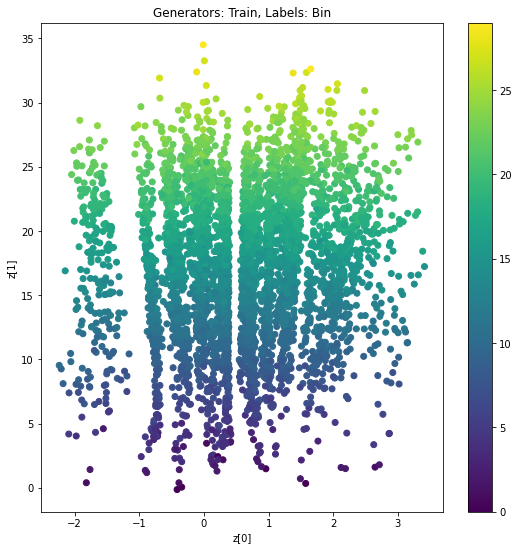

In [6]:
regression_vae.plots(train_data_sequences_flat, np.array(train_data_PR['Bin']), "Train")

## Examples of generation from latent space


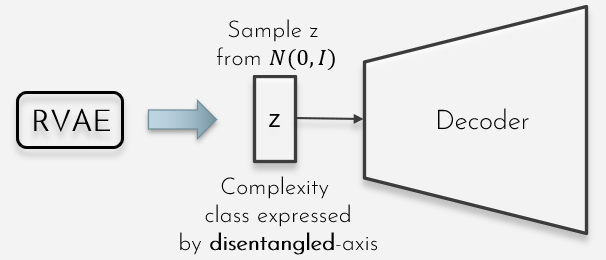

**Set the boolean depending on the complexity axis (vertical or horizontal)**

Generate sequence with a X complexity
- Move in the range for that complexity value on the Harmonic Complexity Axis
- Move freely on the other axis

In [7]:
is_vertical = #True 
latent_space_manager = LatentSpaceManagerRVAE(df, df_sequences, regression_vae.encoder, is_vertical)
generator_RVAE = GeneratorRVAE(latent_space_manager, regression_vae.decoder)


In [9]:
# 1st Method: indicating the complexity bin [0-4]
print(get_chords_sequence_symbolic_from_piano_roll(generator_RVAE.generate_with_complexity_reduced(4)))
print(get_chords_sequence_symbolic_from_piano_roll(generator_RVAE.generate_with_complexity_reduced(0)))

Range on c-axis for the complexity bin (reduced)  4 :
[27.37, 29.43, 29.69, 32.6, 32.45, 33.38]
Z:  29.0832   -0.9745
['Cmin', 'D#7', 'Emin', 'F#7', 'Cmin']
Range on c-axis for the complexity bin (reduced)  0 :
[1.48, 2.42, 2.4, 3.48, 4.58, 5.52]
Z:  2.4133   -1.973
['Cmin', 'G7', 'Cmin', 'G7', 'Cmin']


In [10]:
# 2nd method: indicating the complexity bin [0-4] + free axis coord
print(get_chords_sequence_symbolic_from_piano_roll(generator_RVAE.generate_with_complexity_reduced_and_z_free(0,-0.8)))
print(get_chords_sequence_symbolic_from_piano_roll(generator_RVAE.generate_with_complexity_reduced_and_z_free(0,-0.9)))
print(get_chords_sequence_symbolic_from_piano_roll(generator_RVAE.generate_with_complexity_reduced_and_z_free(0,-1)))
print(get_chords_sequence_symbolic_from_piano_roll(generator_RVAE.generate_with_complexity_reduced_and_z_free(0,-1.3)))

Range on c-axis for the complexity bin (reduced)  0 :
[1.48, 2.42, 2.4, 3.48, 4.58, 5.52]
Z:  -0.8   4.921
['Cmin', 'D#maj', 'Fmin', 'Fmin', 'Cmin']
Range on c-axis for the complexity bin (reduced)  0 :
[1.48, 2.42, 2.4, 3.48, 4.58, 5.52]
Z:  -0.9   4.8156
['Cmin', 'D#maj', 'Fmin', 'Fmin', 'Cmin']
Range on c-axis for the complexity bin (reduced)  0 :
[1.48, 2.42, 2.4, 3.48, 4.58, 5.52]
Z:  -1   2.3949
['Cmin', 'Gmin', 'G#maj', 'G7', 'Cmin']
Range on c-axis for the complexity bin (reduced)  0 :
[1.48, 2.42, 2.4, 3.48, 4.58, 5.52]
Z:  -1.3   2.3122
['Cmin', 'Gmaj', 'G#maj', 'G7', 'Cmin']


In [11]:
# 3rd method: indicating c-axis and free axis coordinates
c_bin = 0
print("Range on c-axis for complexity bin: ", c_bin)
print(latent_space_manager.get_range_of_complexity_bin_reduced(c_bin))

print(get_chords_sequence_symbolic_from_piano_roll(generator_RVAE.generate_with_z_complexity_and_z_free(-5, 4)))
print(get_chords_sequence_symbolic_from_piano_roll(generator_RVAE.generate_with_z_complexity_and_z_free(30, -1.2)))


Range on c-axis for complexity bin:  0
[1.48, 2.42, 2.4, 3.48, 4.58, 5.52]
Z-complexity axis value may be out of range and cause an invalid value
Z:  4   -5
['Cmaj', 'Gmaj', 'Fmaj', 'Gmaj', 'Cmaj']
Harmonic complexity reduced bin is  4
Z:  -1.2   30
['Cmin', 'D#7', 'Emin', 'F#7', 'Cmin']


## Generation of chords sequence

**Generation in Symbolic domain -> Conversion into Midi format -> Conversion in wav format**

In [12]:
!apt install fluidsynth
!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-470
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  fluid-soundfont-gm libfluidsynth1 libqt5x11extras5 qsynth
Suggested packages:
  fluid-soundfont-gs timidity jackd
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libfluidsynth1 libqt5x11extras5 qsynth
0 upgraded, 5 newly installed, 0 to remove and 39 not upgraded.
Need to get 120 MB of archives.
After this operation, 150 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fluid-soundfont-gm all 3.1-5.1 [119 MB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libfluidsynth1 amd64 1.1.9-1 [137 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fluidsynth amd64 1.1.9-1 [20.7 kB]
Get:4 http://archive.ub

Generates a sequence of chords with the indicated complexity value, transforms it into midi and then into wav using FluidSynth

In [13]:
# *********
# Harmonic complexity bin to set for the chords sequence generation
# *********
harmonic_complexity_bin = 4

# method 1
generated_seq = generator_RVAE.generate_with_complexity_reduced(harmonic_complexity_bin)


"""
# method 2
z_free = -1.2
generated_seq = generator_cvae.generate_with_complexity_reduced_and_z_free(harmonic_complexity_bin, z_free)
"""

"""
# method 3
z_c = 14
z_free = 0.5
generated_seq = generator_cvae.generate_with_complexity_and_z_coord(generate_with_z_complexity_and_z_free, z_c, z_free)
"""


print("Generated sequence:")
print(get_chords_sequence_symbolic_from_piano_roll(generated_seq))
print("\n")


# convert to MIDI
path = 'Generated_outputs/'
filename = "generated_RVAE_" + str(harmonic_complexity_bin)
midi_name = filename + ".mid"
symbolic_2_midi(generated_seq, filename)

# convert to .wav
wav_synthesis.midi_2_wav(path + midi_name, path + filename + '.wav')
Audio(path + filename + '.wav')

Range on c-axis for the complexity bin (reduced)  4 :
[27.37, 29.43, 29.69, 32.6, 32.45, 33.38]
Z:  27.9952   0.448
Generated sequence:
['Cmin', 'G#7', 'A7', 'F#7', 'Cmin']


generating voicings for  C D# G  ...2781 voicings found
generating voicings for  C D# F# G#  ...11601 voicings found
generating voicings for  C# E G A  ...9211 voicings found
generating voicings for  C# E F# A#  ...4286 voicings found
generating voicings for  C D# G  ...2781 voicings found
computing observations.....
computing transitions....
Midi Created
FluidSynth version 1.1.9
Copyright (C) 2000-2018 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of E-mu Systems, Inc.

Rendering audio to file 'Generated_outputs/generated_RVAE_4.wav'..


